In [2]:
#!apt-get install -y quarto-cli


In [3]:
#!wget https://github.com/quarto-dev/quarto-cli/releases/download/v1.3.340/quarto-1.3.340-linux-amd64.deb
#!sudo dpkg -i quarto-1.3.340-linux-amd64.deb


In [4]:
!quarto --version


1.5.57


# Projet Données Massives
Avec ce notebook, nous avons pour but d'analyser les ventes d'une entreprise dans le domaine électronique.
Notre [jeu de données](https://www.kaggle.com/datasets/darkovichcycy/bd-sales?resource=download&select=Sales_August_2019.csv) provient de Kaggle

## Configuration

In [5]:
!pyspark --version

24/10/05 11:00:02 WARN Utils: Your hostname, MacBook-Pro-dAudric.local resolves to a loopback address: 127.0.0.1; using 192.168.1.31 instead (on interface en0)
24/10/05 11:00:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.24
Branch HEAD
Compiled by user heartsavior on 2024-02-15T11:24:58Z
Revision fd86f85e181fc2dc0f50a096855acf83a6cc5d9c
Url https://github.com/apache/spark
Type --help for more information.


In [6]:
#install pyspark
#!pip install pyspark
# Spark SQL
#!pip install pyspark[sql]

In [7]:
#import google drive
#from google.colab import drive
#drive.mount('/content/drive/')

## Importation des librairies

In [1]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

24/10/21 10:43:52 WARN Utils: Your hostname, MacBook-Pro-dAudric.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
24/10/21 10:43:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/21 10:43:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading data

In [2]:
#read the file
data = spark.read\
    .option("delimiter", ",")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .csv('New_Data.csv')

In [10]:
data.printSchema()

root
 |-- Order ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: double (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



In [11]:
data.show(1073)

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  141234|              iPhone|               1|     700.0|01/22/19 21:25|944 Walnut St, Bo...|
|  141235|Lightning Chargin...|               1|     14.95|01/28/19 14:15|185 Maple St, Por...|
|  141236|    Wired Headphones|               2|     11.99|01/17/19 13:33|538 Adams St, San...|
|  141237|    27in FHD Monitor|               1|    149.99|01/05/19 20:33|738 10th St, Los ...|
|  141238|    Wired Headphones|               1|     11.99|01/25/19 11:59|387 10th St, Aust...|
|  141239|AAA Batteries (4-...|               1|      2.99|01/29/19 20:22|775 Willow St, Sa...|
|  141240|27in 4K Gaming Mo...|               1|    389.99|01/26/19 12:16|979 Park St, Los ...|
|  141241|USB-C Charging Cable|         

In [12]:
data_rdd = data.rdd
data_rdd.take(5)

[Row(Order ID=141234, Product='iPhone', Quantity Ordered=1, Price Each=700.0, Order Date='01/22/19 21:25', Purchase Address='944 Walnut St, Boston, MA 02215'),
 Row(Order ID=141235, Product='Lightning Charging Cable', Quantity Ordered=1, Price Each=14.95, Order Date='01/28/19 14:15', Purchase Address='185 Maple St, Portland, OR 97035'),
 Row(Order ID=141236, Product='Wired Headphones', Quantity Ordered=2, Price Each=11.99, Order Date='01/17/19 13:33', Purchase Address='538 Adams St, San Francisco, CA 94016'),
 Row(Order ID=141237, Product='27in FHD Monitor', Quantity Ordered=1, Price Each=149.99, Order Date='01/05/19 20:33', Purchase Address='738 10th St, Los Angeles, CA 90001'),
 Row(Order ID=141238, Product='Wired Headphones', Quantity Ordered=1, Price Each=11.99, Order Date='01/25/19 11:59', Purchase Address='387 10th St, Austin, TX 73301')]

In [13]:
data.describe().show()

24/10/05 11:00:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------+------------------+-----------------+--------------+--------------------+
|summary|         Order ID|     Product|  Quantity Ordered|       Price Each|    Order Date|    Purchase Address|
+-------+-----------------+------------+------------------+-----------------+--------------+--------------------+
|  count|           185950|      186304|            185950|           185950|        186304|              186304|
|   mean|230417.5693788653|        NULL|1.1243828986286637|184.3997347674939|          NULL|                NULL|
| stddev|51512.73710999622|        NULL|0.4427926240286705|332.7313298843429|          NULL|                NULL|
|    min|           141234|20in Monitor|                 1|             2.99|01/01/19 03:07|1 11th St, Atlant...|
|    max|           319670|      iPhone|                 9|           1700.0|    Order Date|    Purchase Address|
+-------+-----------------+------------+------------------+-----------------+-----------

## Data cleaning

In [3]:
# dropna
data = data.dropna()

# Filter out invalid transactions (e.g., negative or zero quantities)
data = data.filter((data['`Quantity Ordered`'] > 0) & (data['`Price Each`'] > 0))

data.show(1073)

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  141234|              iPhone|               1|     700.0|01/22/19 21:25|944 Walnut St, Bo...|
|  141235|Lightning Chargin...|               1|     14.95|01/28/19 14:15|185 Maple St, Por...|
|  141236|    Wired Headphones|               2|     11.99|01/17/19 13:33|538 Adams St, San...|
|  141237|    27in FHD Monitor|               1|    149.99|01/05/19 20:33|738 10th St, Los ...|
|  141238|    Wired Headphones|               1|     11.99|01/25/19 11:59|387 10th St, Aust...|
|  141239|AAA Batteries (4-...|               1|      2.99|01/29/19 20:22|775 Willow St, Sa...|
|  141240|27in 4K Gaming Mo...|               1|    389.99|01/26/19 12:16|979 Park St, Los ...|
|  141241|USB-C Charging Cable|         

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Étape 1 : Assembler les colonnes numériques en un vecteur
numeric_columns = ["Quantity Ordered", "Price Each"]  # Remplacer par les colonnes de ton dataset
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")

# Étape 2 : Normaliser les données avec StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Étape 3 : Appliquer l'ACP (PCA)
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")  # Réduction à 2 composantes principales

# Étape 4 : Construire le pipeline
pipeline = Pipeline(stages=[assembler, scaler, pca])

# Entraîner le pipeline
model = pipeline.fit(data)

# Transformer les données
pca_result = model.transform(data)

# Afficher les résultats de l'ACP
pca_result.show(truncate=False)


24/10/21 10:44:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+--------+--------------------------+----------------+----------+--------------+---------------------------------------+------------+------------------------------------------+------------------------------------------+
|Order ID|Product                   |Quantity Ordered|Price Each|Order Date    |Purchase Address                       |features    |scaled_features                           |pca_features                              |
+--------+--------------------------+----------------+----------+--------------+---------------------------------------+------------+------------------------------------------+------------------------------------------+
|141234  |iPhone                    |1               |700.0     |01/22/19 21:25|944 Walnut St, Boston, MA 02215        |[1.0,700.0] |[-0.2809055342814478,1.5495993882265664]  |[1.294362443701784,0.8971020273728293]    |
|141235  |Lightning Charging Cable  |1               |14.95     |01/28/19 14:15|185 Maple St, Portland, OR 97035       |

24/10/21 10:44:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [15]:
# Convert Order Date to date type and extract month and year
#data = data.withColumn("OrderDate", to_date(col("Order Date"), "MM/dd/yy HH:mm"))
#data = data.withColumn("Month", month(col("OrderDate"))).withColumn("Year", year(col("OrderDate")))

data.show(5)

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  141234|              iPhone|               1|     700.0|01/22/19 21:25|944 Walnut St, Bo...|
|  141235|Lightning Chargin...|               1|     14.95|01/28/19 14:15|185 Maple St, Por...|
|  141236|    Wired Headphones|               2|     11.99|01/17/19 13:33|538 Adams St, San...|
|  141237|    27in FHD Monitor|               1|    149.99|01/05/19 20:33|738 10th St, Los ...|
|  141238|    Wired Headphones|               1|     11.99|01/25/19 11:59|387 10th St, Aust...|
+--------+--------------------+----------------+----------+--------------+--------------------+
only showing top 5 rows



In [16]:
data.describe().show()

+-------+-----------------+------------+------------------+-----------------+--------------+--------------------+
|summary|         Order ID|     Product|  Quantity Ordered|       Price Each|    Order Date|    Purchase Address|
+-------+-----------------+------------+------------------+-----------------+--------------+--------------------+
|  count|           185950|      185950|            185950|           185950|        185950|              185950|
|   mean|230417.5693788653|        NULL|1.1243828986286637|184.3997347674939|          NULL|                NULL|
| stddev|51512.73710999622|        NULL|0.4427926240286705|332.7313298843429|          NULL|                NULL|
|    min|           141234|20in Monitor|                 1|             2.99|01/01/19 03:07|1 11th St, Atlant...|
|    max|           319670|      iPhone|                 9|           1700.0|12/31/19 23:53|999 Wilson St, Sa...|
+-------+-----------------+------------+------------------+-----------------+-----------

## Analysis

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest

# Indexer les colonnes catégorielles (par exemple, 'Product')
indexer = StringIndexer(inputCol="Product", outputCol="ProductIndex")

# Assembler les features en un vecteur pour le test
assembler = VectorAssembler(inputCols=["ProductIndex"], outputCol="features")

# Création du pipeline
pipeline = Pipeline(stages=[indexer, assembler])

# Entrainement du pipeline sur les données
model = pipeline.fit(data)

# Transformation des données pour inclure les index et les vecteurs
transformed_df = model.transform(data)

# Appliquer le test du chi-deux
chi_square_result = ChiSquareTest.test(transformed_df, "features", "Quantity Ordered")

# Afficher les résultats
chi_square_result.show()


+-------+----------------+--------------------+
|pValues|degreesOfFreedom|          statistics|
+-------+----------------+--------------------+
|  [0.0]|           [144]|[30567.440039563433]|
+-------+----------------+--------------------+



24/10/07 23:49:51 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 753120 ms exceeds timeout 120000 ms
24/10/07 23:49:51 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/07 23:49:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [10]:
from pyspark.sql.functions import col, sum, count, to_date, month, year

In [11]:
# Group by product and sum the quantity ordered
top_selling_products = data.groupBy("Product").agg(sum("`Quantity Ordered`").alias("TotalQuantity"))

# Show top 10 products by quantity sold
print("Les 10 produits les plus vendus sont (sous forme de df) :")
top_selling_products.orderBy("TotalQuantity", ascending=False).show(10)



Les 10 produits les plus vendus sont (sous forme de df) :
+--------------------+-------------+
|             Product|TotalQuantity|
+--------------------+-------------+
|AAA Batteries (4-...|        31017|
|AA Batteries (4-p...|        27635|
|USB-C Charging Cable|        23975|
|Lightning Chargin...|        23217|
|    Wired Headphones|        20557|
|Apple Airpods Hea...|        15661|
|Bose SoundSport H...|        13457|
|    27in FHD Monitor|         7550|
|              iPhone|         6849|
|27in 4K Gaming Mo...|         6244|
+--------------------+-------------+
only showing top 10 rows



In [12]:
from pyspark.sql import Row

# Transformation de l'RDD pour extraire les colonnes nécessaires
product_quantity_rdd = data_rdd.map(lambda row: (row['Product'], row['Quantity Ordered']))

# Agréger les quantités par produit, en gérant les valeurs None
# Si x ou y est None, on le remplace par 0 avant l'addition
total_quantity_per_product_rdd = product_quantity_rdd.reduceByKey(lambda x, y: (x if x is not None else 0) + (y if y is not None else 0))

# Convertir en un RDD de Row pour un affichage facile
top_selling_products_rdd = total_quantity_per_product_rdd.map(lambda x: Row(Product=x[0], TotalQuantity=x[1]))

# Trier les produits par quantité totale commandée en ordre décroissant
sorted_top_selling_products_rdd = top_selling_products_rdd.sortBy(lambda x: x['TotalQuantity'], ascending=False)

print("Les 10 produits les plus vendus sont (sous forme de rdd) :")
sorted_top_selling_products_rdd.take(10)

Les 10 produits les plus vendus sont (sous forme de rdd) :


[Row(Product='AAA Batteries (4-pack)', TotalQuantity=31017),
 Row(Product='AA Batteries (4-pack)', TotalQuantity=27635),
 Row(Product='USB-C Charging Cable', TotalQuantity=23975),
 Row(Product='Lightning Charging Cable', TotalQuantity=23217),
 Row(Product='Wired Headphones', TotalQuantity=20557),
 Row(Product='Apple Airpods Headphones', TotalQuantity=15661),
 Row(Product='Bose SoundSport Headphones', TotalQuantity=13457),
 Row(Product='27in FHD Monitor', TotalQuantity=7550),
 Row(Product='iPhone', TotalQuantity=6849),
 Row(Product='27in 4K Gaming Monitor', TotalQuantity=6244)]

In [13]:
# Calculate total revenue for each product
data = data.withColumn("Revenue", col("Quantity Ordered") * col("Price Each"))

# Group by product and calculate total revenue
revenue_by_product = data.groupBy("Product").agg(sum("Revenue").alias("TotalRevenue"))

print("Les 10 produits les plus rentables sont :")
# Show top 10 products by revenue
revenue_by_product.orderBy("TotalRevenue", ascending=False).show(10)


Les 10 produits les plus rentables sont :
+--------------------+------------------+
|             Product|      TotalRevenue|
+--------------------+------------------+
|  Macbook Pro Laptop|         8037600.0|
|              iPhone|         4794300.0|
|     ThinkPad Laptop|4129958.6999999676|
|        Google Phone|         3319200.0|
|27in 4K Gaming Mo...|2435097.5599999577|
|34in Ultrawide Mo...|2355558.0099999583|
|Apple Airpods Hea...|         2349150.0|
|       Flatscreen TV|         1445700.0|
|Bose SoundSport H...|1345565.4299999368|
|    27in FHD Monitor|1132424.4999999707|
+--------------------+------------------+
only showing top 10 rows



In [14]:
# Convert Order Date to date type and extract month and year
data = data.withColumn("OrderDate", to_date(col("Order Date"), "MM/dd/yy HH:mm"))
data = data.withColumn("Month", month(col("OrderDate"))).withColumn("Year", year(col("OrderDate")))
# Group by year and month to get monthly sales
monthly_sales = data.groupBy("Year", "Month").agg(sum("Revenue").alias("TotalRevenue"))

# Show sales trends
monthly_sales.orderBy("Year", "Month").show()


+----+-----+------------------+
|Year|Month|      TotalRevenue|
+----+-----+------------------+
|2019|    1|1813586.4399999138|
|2019|    2|2202022.4199999087|
|2019|    3|2807100.3800003603|
|2019|    4|3390670.2400007015|
|2019|    5|3152606.7500005495|
|2019|    6|2577802.2600001753|
|2019|    7|2647775.7600002354|
|2019|    8| 2244467.879999913|
|2019|    9| 2097560.129999891|
|2019|   10|3736726.8800009675|
|2019|   11|3199603.2000005865|
|2019|   12| 4613443.340000139|
|2020|    1| 8670.289999999999|
+----+-----+------------------+



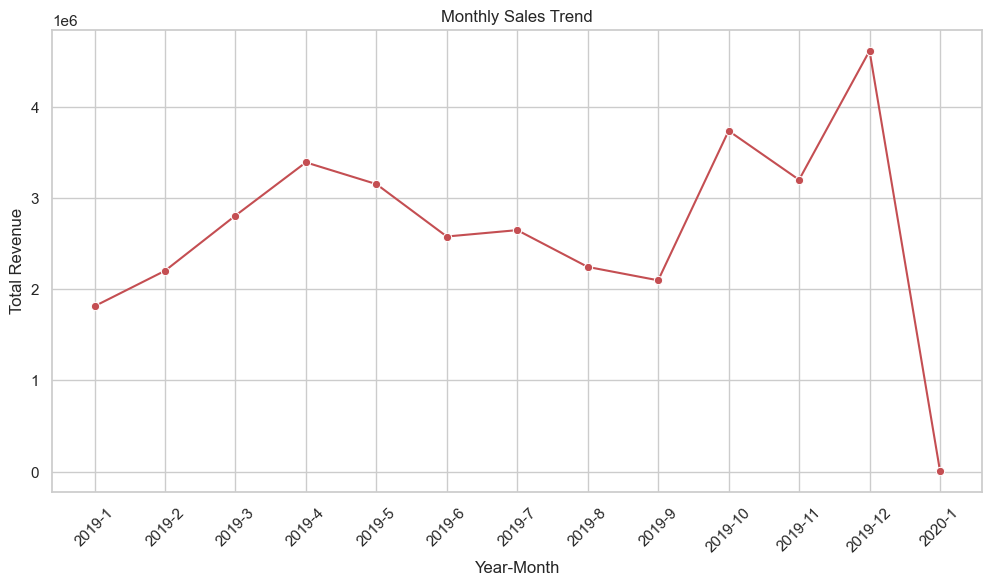

In [15]:
import seaborn as sns

import matplotlib.pyplot as plt

# Convertir en DataFrame Pandas
monthly_sales_pd = monthly_sales.orderBy("Year", "Month").toPandas()

# Combiner l'année et le mois en une seule colonne pour une meilleure visualisation
monthly_sales_pd['YearMonth'] = monthly_sales_pd['Year'].astype(str) + '-' + monthly_sales_pd['Month'].astype(str)

# Configuration du style Seaborn
sns.set(style="whitegrid")

# Création du graphique de tendance des ventes mensuelles
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_sales_pd,
    x='YearMonth',
    y='TotalRevenue',
    marker='o',
    color='r'
)

# Configuration des axes et des labels
plt.title('Monthly Sales Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)

# Affichage du graphique
plt.show()


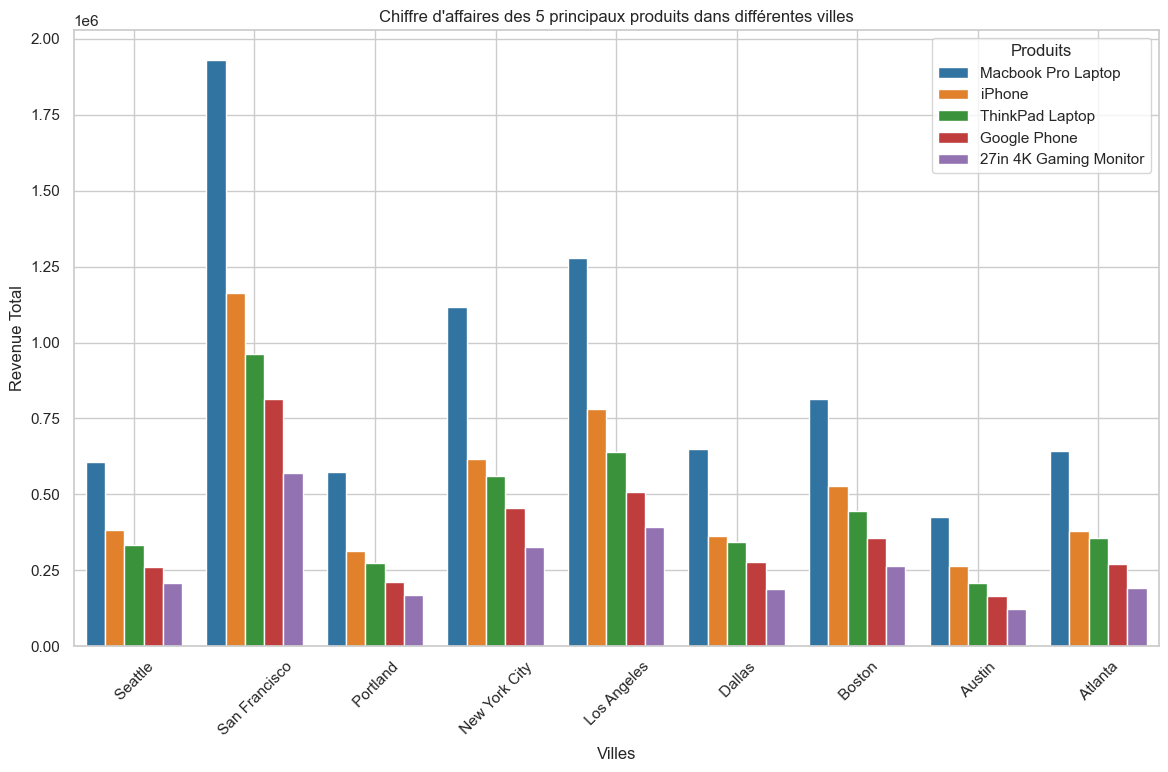

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum, split

# Obtenir les 5 produits les plus rentables
top_5_products = revenue_by_product.orderBy("TotalRevenue", ascending=False).limit(5)

# Récupérer les noms des 5 produits les plus rentables
top_5_product_names = [row['Product'] for row in top_5_products.collect()]

# Extraire la ville à partir de l'adresse d'achat (en supposant que l'adresse est au format "Rue, Ville, État ZIP")
data = data.withColumn("City", split(data["Purchase Address"], ",")[1])

# Filtrer les données pour ne conserver que les 5 produits les plus rentables
filtered_data = data.filter(data['Product'].isin(top_5_product_names))

# Regrouper par produit et ville pour obtenir le revenu par produit et par ville
product_city_performance = filtered_data.groupBy("City", "Product").agg(
    sum("Revenue").alias("TotalRevenue")
)

# Convertir en Pandas pour une analyse plus facile
product_city_performance_pd = product_city_performance.orderBy("City", "TotalRevenue", ascending=False).toPandas()

# Création du graphique avec Seaborn
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Barplot avec Seaborn
sns.barplot(
    data=product_city_performance_pd,
    x="City",
    y="TotalRevenue",
    hue="Product",
    palette="tab10"
)

# Configuration des axes et des labels
plt.xlabel('Villes')
plt.ylabel('Revenue Total')
plt.title("Chiffre d'affaires des 5 principaux produits dans différentes villes")
plt.xticks(rotation=45)
plt.legend(title='Produits')
plt.grid(True)

# Affichage du graphique
plt.show()

In [32]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

def calculate_correlation_matrix(df, cols):
    """
    Calcule la matrice de corrélation pour les colonnes spécifiées dans un fichier CSV.

    Args:
    file_path (str): Chemin vers le fichier CSV.
    cols (list of str): Liste des noms des colonnes pour lesquelles la corrélation doit être calculée.

    Returns:
    correlation_matrix: Matrice de corrélation.
    """

    # Sélection des colonnes pertinentes pour la corrélation
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    vector_data = assembler.transform(df).select("features")

    # Calcul de la matrice de corrélation
    correlation_matrix = Correlation.corr(vector_data, "features").head()[0]

    return correlation_matrix

# Exemple d'utilisation
columns = ["Quantity Ordered", "Price Each"]
correlation_matrix = calculate_correlation_matrix(data, columns)
print("Matrice de corrélation :\n", correlation_matrix)


Matrice de corrélation :
 DenseMatrix([[ 1.        , -0.14827234],
             [-0.14827234,  1.        ]])


24/10/02 11:06:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## ML

In [41]:
from pyspark.sql.functions import col, sum , mean
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline



# Conversion des colonnes en types numériques
df = data.withColumn("Quantity Ordered", col("Quantity Ordered").cast("float"))
df = data.withColumn("Price Each", col("Price Each").cast("float"))

# Agrégation des données par produit
product_group_df = df.groupBy("Product").agg(
    sum("Quantity Ordered").alias("Total Quantity Ordered"),
    mean("Price Each").alias("Average Price Each")
)


# Assembler les features en un vecteur
assembler = VectorAssembler(
    inputCols=["Total Quantity Ordered", "Average Price Each"],
    outputCol="features"
)

# Normalisation des données
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Appliquer KMeans
kmeans = KMeans(featuresCol='scaled_features', k=3, seed=42)

# Définir les étapes du pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

#Entrainement du model
model = pipeline.fit(product_group_df)

#application du modele
clusters_df = model.transform(product_group_df)

# Renommer la colonne 'prediction' en 'cluster'
clusters_df = clusters_df.withColumnRenamed('prediction', 'cluster')

# Afficher les résultats
clusters_df.select("Product", "Total Quantity Ordered", "Average Price Each", "cluster").show()




+--------------------+----------------------+------------------+-------+
|             Product|Total Quantity Ordered|Average Price Each|cluster|
+--------------------+----------------------+------------------+-------+
|    Wired Headphones|                 20557|11.989999771118164|      1|
|  Macbook Pro Laptop|                  4728|            1700.0|      2|
|Apple Airpods Hea...|                 15661|             150.0|      1|
|              iPhone|                  6849|             700.0|      0|
|Lightning Chargin...|                 23217|14.949999809265137|      1|
|Bose SoundSport H...|                 13457| 99.98999786376953|      1|
|USB-C Charging Cable|                 23975|11.949999809265137|      1|
|AAA Batteries (4-...|                 31017| 2.990000009536743|      1|
|        20in Monitor|                  4129|109.98999786376953|      0|
|    27in FHD Monitor|                  7550|149.99000549316406|      0|
|     Vareebadd Phone|                  2068|      

In [16]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Étape 1 : Assembler les colonnes numériques en un vecteur
numeric_columns = ["Quantity Ordered", "Price Each"]  # Adapter selon tes colonnes
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")

# Étape 2 : Normaliser les données avec StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Étape 3 : Appliquer l'ACP (PCA)
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")  # Réduction à 2 composantes principales

# Étape 4 : Appliquer KMeans pour le clustering en utilisant les "pca_features"
kmeans = KMeans(k=3, seed=42, featuresCol="pca_features", predictionCol="cluster")  # 3 clusters

# Étape 5 : Construire le pipeline avec les étapes ACP et clustering
pipeline = Pipeline(stages=[assembler, scaler, pca, kmeans])

# Entraîner le pipeline
model = pipeline.fit(data)

# Transformer les données
cluster_result = model.transform(data)

# Afficher les résultats avec les clusters
cluster_result.select("pca_features", "cluster","Product").show(truncate=False)


+------------------------------------------+-------+--------------------------+
|pca_features                              |cluster|Product                   |
+------------------------------------------+-------+--------------------------+
|[1.294362443701784,0.8971020273728293]    |0      |iPhone                    |
|[-0.16147731933095677,-0.5587377356566288]|0      |Lightning Charging Cable  |
|[-1.7646931722593822,1.0318971795377958]  |1      |Wired Headphones          |
|[0.12550407122439153,-0.2717563451019275] |0      |27in FHD Monitor          |
|[-0.16776778819976473,-0.5650282045254225]|0      |Wired Headphones          |
|[-0.18689421381438356,-0.5841546301399982]|0      |AAA Batteries (4-pack)    |
|[0.6355420876142285,0.2382816712867594]   |0      |27in 4K Gaming Monitor    |
|[-0.16785279453582974,-0.5651132108614874]|0      |USB-C Charging Cable      |
|[0.0192461511431755,-0.37801426518290393] |0      |Bose SoundSport Headphones|
|[0.12552532280840775,-0.271735093517911

In [9]:
a = 'toto'


In [14]:
hash(a)

1853016237931324040

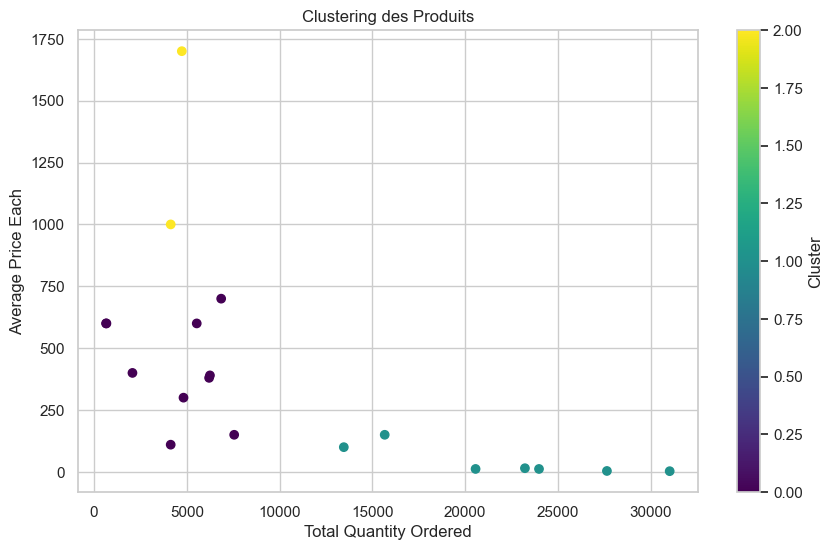

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir les résultats PySpark en DataFrame Pandas pour la visualisation
result_pd = clusters_df.toPandas()

# Créer le scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(result_pd['Total Quantity Ordered'], result_pd['Average Price Each'], c=result_pd['cluster'], cmap='viridis')
plt.xlabel('Total Quantity Ordered')
plt.ylabel('Average Price Each')
plt.title('Clustering des Produits')
plt.colorbar(label='Cluster')
plt.show()


## ARIMA

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, expr
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

def arima_manual_pyspark(data, p, d, q,partition_column=None):
    """
    Implémente manuellement un modèle ARIMA en PySpark.

    :param data: PySpark DataFrame avec au moins deux colonnes: 'date' et 'validations'
    :param p: Ordre du processus autoregressif (AR)
    :param d: Nombre de différenciations (Integrated)
    :param q: Ordre du processus de moyenne mobile (MA)
    :return: DataFrame avec les prédictions ARIMA
    """
    # Trier les données par date
    data = data.orderBy("date")

    if partition_column:
        window = Window.partitionBy(partition_column).orderBy("date")
    else:
        window = Window.orderBy("date")
    # Différenciation : d différences
    window = Window.orderBy("date")
    for i in range(d):
        data = data.withColumn(f'diff_validations_{i+1}', col("validations") - lag(col("validations"), 1).over(window))
        data = data.fillna(0, subset=[f'diff_validations_{i+1}'])
    
    # Utiliser la dernière différenciation comme colonne cible
    target_column = f'diff_validations_{d}'

    # Ajouter les valeurs différenciées passées (p lags) pour la partie AR
    for i in range(1, p+1):
        data = data.withColumn(f'lag_{i}', lag(col(target_column), i).over(window))
    
    data = data.fillna(0)  # Remplir les valeurs nulles causées par le lag
    
    # Création du vecteur de caractéristiques pour la partie AR
    ar_features = [f'lag_{i}' for i in range(1, p+1)]
    assembler = VectorAssembler(inputCols=ar_features, outputCol='ar_features')
    data = assembler.transform(data)
    
    # Appliquer une régression linéaire sur les termes AR
    lr_ar = LinearRegression(featuresCol='ar_features', labelCol=target_column)
    ar_model = lr_ar.fit(data)
    data = ar_model.transform(data).withColumnRenamed('prediction', 'ar_prediction')
    
    # Calcul des erreurs résiduelles pour la partie MA
    data = data.withColumn('error', col(target_column) - col('ar_prediction'))
    
    # Ajouter les termes de moyenne mobile (q lags) pour la partie MA
    for i in range(1, q+1):
        data = data.withColumn(f'error_lag_{i}', lag(col('error'), i).over(window))
    
    data = data.fillna(0)  # Remplir les valeurs nulles causées par le lag des erreurs
    
    # Création du vecteur de caractéristiques pour la partie MA
    ma_features = [f'error_lag_{i}' for i in range(1, q+1)]
    assembler = VectorAssembler(inputCols=ma_features, outputCol='ma_features')
    data = assembler.transform(data)
    
    # Combiner les termes AR et MA
    final_features = ['ar_features', 'ma_features']
    assembler = VectorAssembler(inputCols=final_features, outputCol='final_features')
    data = assembler.transform(data)
    
    # Ajuster un modèle final ARIMA avec les termes AR et MA
    lr_final = LinearRegression(featuresCol='final_features', labelCol=target_column)
    final_model = lr_final.fit(data)
    data = final_model.transform(data).withColumnRenamed('prediction', 'final_prediction')
    
    # Revenir à la série originale en annulant les différences (intégration inverse)
    data = data.withColumn('predicted_validations', expr(f'final_prediction + validations'))
    
    # Sélectionner les colonnes finales (date et prédictions)
    result = data.select("date", "validations", "predicted_validations")
    
    return result

# Exemple d'utilisation de la fonction
# Créer une session Spark


In [3]:
from pyspark.sql.functions import to_date

In [4]:

# Charger les données en DataFrame Spark
data = spark.read.csv("New_Data.csv", header=True, inferSchema=True)
data.show(5)

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  141234|              iPhone|               1|     700.0|01/22/19 21:25|944 Walnut St, Bo...|
|  141235|Lightning Chargin...|               1|     14.95|01/28/19 14:15|185 Maple St, Por...|
|  141236|    Wired Headphones|               2|     11.99|01/17/19 13:33|538 Adams St, San...|
|  141237|    27in FHD Monitor|               1|    149.99|01/05/19 20:33|738 10th St, Los ...|
|  141238|    Wired Headphones|               1|     11.99|01/25/19 11:59|387 10th St, Aust...|
+--------+--------------------+----------------+----------+--------------+--------------------+
only showing top 5 rows



In [5]:
data = data.withColumnRenamed("Order Date", "date")
data = data.withColumnRenamed("Quantity Ordered", "validations")


In [19]:
data = data.withColumn("date", to_date(col("date"), "MM/dd/yy HH:mm"))
data = data.withColumn("validations", col("validations").cast("int"))
data.show(5)

+--------+--------------------+-----------+----------+----------+--------------------+
|Order ID|             Product|validations|Price Each|      date|    Purchase Address|
+--------+--------------------+-----------+----------+----------+--------------------+
|  141234|              iPhone|          1|     700.0|2019-01-22|944 Walnut St, Bo...|
|  141235|Lightning Chargin...|          1|     14.95|2019-01-28|185 Maple St, Por...|
|  141236|    Wired Headphones|          2|     11.99|2019-01-17|538 Adams St, San...|
|  141237|    27in FHD Monitor|          1|    149.99|2019-01-05|738 10th St, Los ...|
|  141238|    Wired Headphones|          1|     11.99|2019-01-25|387 10th St, Aust...|
+--------+--------------------+-----------+----------+----------+--------------------+
only showing top 5 rows



In [20]:
data.printSchema()

root
 |-- Order ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- validations: integer (nullable = true)
 |-- Price Each: double (nullable = true)
 |-- date: date (nullable = true)
 |-- Purchase Address: string (nullable = true)



In [6]:
from pyspark.sql.functions import col, sum

# Assurez-vous que la colonne 'validations' est correctement nommée
# Convertir la colonne 'validations' en type entier en gérant les erreurs
data = data.withColumn("validations", col("validations").cast("int"))

# Si vous avez encore des erreurs, vous pouvez également gérer les valeurs nulles avec fillna
data = data.fillna(0, subset=['validations'])

# Agréger les données par date après conversion en int
data_aggregated = data.groupBy("date").agg(sum("validations").alias("quantity_sold"))

# Afficher les résultats
data_aggregated.show(5)


+--------------+-------------+
|          date|quantity_sold|
+--------------+-------------+
|01/12/19 18:51|            2|
|01/07/19 13:25|            1|
|01/18/19 10:44|            1|
|01/05/19 17:27|            1|
|01/16/19 22:04|            1|
+--------------+-------------+
only showing top 5 rows



In [7]:


# Appel de la fonction ARIMA avec p=2, d=1, q=2
result = arima_manual_pyspark(data_aggregated, p=2, d=1, q=2,)

# Afficher les résultats
result.show()


NameError: name 'arima_manual_pyspark' is not defined

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, expr
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

def arima_manual_pyspark(data, p, d, q, partition_column=None):
    """
    Implémente manuellement un modèle ARIMA en PySpark avec partitionnement.
    
    :param data: PySpark DataFrame avec au moins deux colonnes: 'date' et 'quantity_sold'
    :param p: Ordre du processus autoregressif (AR)
    :param d: Nombre de différenciations (Integrated)
    :param q: Ordre du processus de moyenne mobile (MA)
    :param partition_column: Colonne sur laquelle partitionner les données pour éviter l'avertissement
    :return: DataFrame avec les prédictions ARIMA
    """
    # Trier les données par date
    data = data.orderBy("date")

    # Créer la fenêtre avec partitionnement si la colonne de partition est fournie
    if partition_column:
        window = Window.partitionBy(partition_column).orderBy("date")
    else:
        window = Window.orderBy("date")

    # Différenciation : d différences
    for i in range(d):
        data = data.withColumn(f'diff_quantity_sold_{i+1}', col("quantity_sold") - lag(col("quantity_sold"), 1).over(window))
        data = data.fillna(0, subset=[f'diff_quantity_sold_{i+1}'])

    # Utiliser la dernière différenciation comme colonne cible
    target_column = f'diff_quantity_sold_{d}'

    # Ajouter les valeurs différenciées passées (p lags) pour la partie AR
    for i in range(1, p+1):
        data = data.withColumn(f'lag_{i}', lag(col(target_column), i).over(window))

    data = data.fillna(0)  # Remplir les valeurs nulles causées par le lag

    # Création du vecteur de caractéristiques pour la partie AR
    ar_features = [f'lag_{i}' for i in range(1, p+1)]
    assembler = VectorAssembler(inputCols=ar_features, outputCol='ar_features')
    data = assembler.transform(data)

    # Appliquer une régression linéaire sur les termes AR
    lr_ar = LinearRegression(featuresCol='ar_features', labelCol=target_column)
    ar_model = lr_ar.fit(data)
    data = ar_model.transform(data).withColumnRenamed('prediction', 'ar_prediction')

    # Calcul des erreurs résiduelles pour la partie MA
    data = data.withColumn('error', col(target_column) - col('ar_prediction'))

    # Ajouter les termes de moyenne mobile (q lags) pour la partie MA
    for i in range(1, q+1):
        data = data.withColumn(f'error_lag_{i}', lag(col('error'), i).over(window))

    data = data.fillna(0)  # Remplir les valeurs nulles causées par le lag des erreurs

    # Création du vecteur de caractéristiques pour la partie MA
    ma_features = [f'error_lag_{i}' for i in range(1, q+1)]
    assembler = VectorAssembler(inputCols=ma_features, outputCol='ma_features')
    data = assembler.transform(data)

    # Combiner les termes AR et MA
    final_features = ['ar_features', 'ma_features']
    assembler = VectorAssembler(inputCols=final_features, outputCol='final_features')
    data = assembler.transform(data)

    # Ajuster un modèle final ARIMA avec les termes AR et MA
    lr_final = LinearRegression(featuresCol='final_features', labelCol=target_column)
    final_model = lr_final.fit(data)
    data = final_model.transform(data).withColumnRenamed('prediction', 'final_prediction')

    # Revenir à la série originale en annulant les différences (intégration inverse)
    data = data.withColumn('predicted_quantity_sold', expr(f'final_prediction + quantity_sold'))

    # Sélectionner les colonnes finales (date et prédictions)
    result = data.select("date", "quantity_sold", "predicted_quantity_sold")

    return result

# Appel de la fonction avec partitionnement
result = arima_manual_pyspark(data_aggregated, p=2, d=1, q=2, partition_column=None)

# Afficher les résultats
result.show()


## Streaming with socket 

In [8]:
from pyspark.sql.functions import explode, split, current_timestamp, window

port = 9999

# df spark représentant le flux d'entrée à partir de la connexion socket
stream = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", port) \
    .load()\
    .withColumn("timestamp", current_timestamp()) \

#Utilisation de fenêtres temporelles
w = stream.withColumn("window", window("timestamp", "1 minute"))

# Définir la fonction qui traite chaque batch de données
def split_words(df, batch_id):
    # Séparer les lignes en mots et sauvegarder le résultat dans une table Spark
    words = df.withColumn("word", explode(split(df["value"], " ")))
    
    # Sauvegarder le DataFrame dans une table Spark
    words.write \
        .mode("append") \
        .saveAsTable("array_words")

# Afficher les résultats en continu
query = w.writeStream \
            .foreachBatch(split_words) \
            .outputMode("append") \
            .start()

# Attendre que la requête se termine
query.awaitTermination()


24/10/21 11:52:26 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.
24/10/21 11:52:26 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/q7/05h3nfts6n3_246h_khmw2z00000gn/T/temporary-955d62f0-0893-4394-a198-481726c0c568. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/10/21 11:52:26 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Users/aaudric/miniconda3/envs/pyspark_env/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
         

KeyboardInterrupt: 

24/10/21 11:52:41 WARN TextSocketMicroBatchStream: Stream closed by localhost:9999
24/10/21 12:56:45 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1057826 ms exceeds timeout 120000 ms
24/10/21 12:56:45 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/21 12:56:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.stor

## Requêtes sur le flux

In [9]:
words = spark.read.table("array_words")
words.show()

+--------------------+--------------------+--------------------+----------+
|               value|           timestamp|              window|      word|
+--------------------+--------------------+--------------------+----------+
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|L'éléphant|
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|   déteste|
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|        la|
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|   musique|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...|L'étudiant|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...| construit|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...|        la|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...|   musique|
|Le professeur con...|2024-10-04 09:07:...|{2024-10-04 09:07...|        Le|
|Le professeur con...|2024-10-04 09:07:...|{2024-10-04 09:07...|professeur|
|Le professe

In [12]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col

words.filter(
    (col("timestamp") >= F.lit("2024-10-04 09:08:00")) & 
    (col("timestamp") <= F.lit("2024-10-04 09:10:00"))
).show()

+--------------------+--------------------+--------------------+----------+
|               value|           timestamp|              window|      word|
+--------------------+--------------------+--------------------+----------+
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|L'éléphant|
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|   déteste|
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|        la|
|L'éléphant détest...|2024-10-04 09:09:...|{2024-10-04 09:09...|   musique|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...|L'étudiant|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...| construit|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...|        la|
|L'étudiant constr...|2024-10-04 09:08:...|{2024-10-04 09:08...|   musique|
|Le professeur con...|2024-10-04 09:08:...|{2024-10-04 09:08...|        Le|
|Le professeur con...|2024-10-04 09:08:...|{2024-10-04 09:08...|professeur|
|Le professe